In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train / 255
x_test = x_test / 255

In [5]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [51]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

hidden_dim = 2
batch_size = 60

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

In [52]:
from keras.models import Model

encoder = Model(input_img, h, name='encoder')
decoder = Model(input_dec, decoded, name='decoder')
vae = Model(input_img, decoder(encoder(input_img)), name="vae")

In [8]:
def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 28*28))
  y = K.reshape(y, shape=(batch_size, 28*28))
  loss = K.sum(K.square(x-y), axis=-1)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return loss + kl_loss

In [9]:
vae.compile(optimizer='adam', loss=vae_loss)

In [10]:
vae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5

1000/1000 [==============================] - 17s 12ms/step - loss: 61.7069
Epoch 2/5
1000/1000 [==============================] - 12s 12ms/step - loss: 44.5575
Epoch 3/5
1000/1000 [==============================] - 12s 12ms/step - loss: 43.4404
Epoch 4/5
1000/1000 [==============================] - 12s 12ms/step - loss: 42.8377
Epoch 5/5
1000/1000 [==============================] - 12s 12ms/step - loss: 42.4319


In [44]:
n = 10
total = 2*n+1

plt.figure(figsize=(total, total))

<Figure size 2100x2100 with 0 Axes>

<Figure size 2100x2100 with 0 Axes>

1/1 [==============================] - 0s 46ms/step


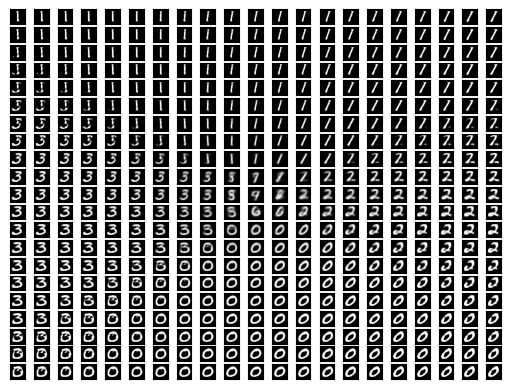

In [45]:
num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = decoder.predict(np.expand_dims([i, j], axis=0))
    plt.imshow(img.squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)